In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from THESIS import LightCurveSampler, ModelComparison, JAXNSmodelCreator
from NSmodels import *
import warnings
from scipy.stats import loguniform, uniform
warnings.filterwarnings("ignore")
import corner
import glob
from pioran.psd import OneBendPowerLaw
from pioran import PSDToACV

INFO[2024-04-17 13:35:22,149]: Unable to initialize backend 'cuda': 
INFO[2024-04-17 13:35:22,150]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-04-17 13:35:22,151]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


## MCMC posteriors

In [203]:
import emcee

In [311]:
def DRW_log_likelihood_model(theta, time = None, y = None, y_errs = None ):
    
    log_amp, log_bend_freq, err_scale = theta
    
    kernel = np.power(10, log_amp) * kernels.Exp(scale = 1/np.power(10,log_bend_freq))
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=0)
    
    return gp.log_probability(y)

# def DRW_log_uniform_prior(theta, time):
    
#     limits = [(-10, 10), (np.log10(1/(time[-1]-time[0])), np.log10( 1/np.min(np.diff(time)))), (1e-3, 0.5)]  # For [m, b]
    
#     for i, (lower, upper) in enumerate(limits):
#         if not (lower < theta[i] < upper):
#             return -np.inf  # Outside the bounds, return negative infinity
    
    
#     log_prior = -np.sum(np.log10(theta[i] / (limits[i][0] * np.log10(upper / lower))))
#     return log_prior

def DRW_log_uniform_prior(theta, time):
    
    limits = [(-10, 10), (-6, 4), (1e-3, 2)]  # For [m, b]
    for i, (lower, upper) in enumerate(limits):
        if not (lower < theta[i] < upper):
            return -np.inf  # Outside the bounds, return negative infinity
        
    log_prior = 0
    for i, (lower, upper) in enumerate(limits[0:2]):
        log_prior += loguniform.logpdf(10**theta[i], 10**lower, 10**upper)

    log_prior += uniform.logpdf(theta[2], loc = limits[2][0], scale = limits[2][1]-limits[2][0])
    
    return log_prior

def DRW_log_posterior(theta, time, y, y_errs):

    lp = DRW_log_uniform_prior(theta, time)
    if not np.isfinite(lp):
        return -np.inf
    return lp + DRW_log_likelihood_model(theta, time, y, y_errs)


In [393]:
def OBPL_log_likelihood_model(theta, n_component=10, time = None, y = None, y_errs = None ):
    
    log_bend_freq, log_norm, alpha_l, alpha_h,  err_scale = theta
    psd = OneBendPowerLaw([np.exp(log_norm), alpha_l, np.power(10, log_bend_freq), alpha_h], free_parameters=[True]*4)
    model_ACV = PSDToACV(psd, S_low=100,
                S_high=20,
                T=time[-1]-time[0],
                dt=0.0001,
                method='SHO',
                n_components=n_component,
                estimate_variance=True,
                init_variance=np.var(y, ddof=1),
                use_celerite=False,
                use_legacy_celerite=False )
    
    kernel = model_ACV.ACVF
    
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=0)
    
    return gp.log_probability(y)


def OBPL_log_uniform_prior(theta, time):
    limits = [(-7, 7), (-10, 10),(-0.25,2), (0.5, 4) ,(0, 1.5)]  
    for i, (lower, upper) in enumerate(limits):
        if not (lower < theta[i] < upper):
            return -np.inf  # Outside the bounds, return negative infinity
        
    log_prior = 0
    for i, (lower, upper) in enumerate(limits[0:2]):
        log_prior += loguniform.logpdf(10**theta[i], 10**lower, 10**upper)

    for i, (lower, upper) in enumerate(limits[2:]):
        log_prior += uniform.logpdf(theta[i+2], loc = lower, scale = upper-lower)
    #log_prior += uniform.logpdf(theta[2], loc = limits[2][0], scale = limits[2][1]-limits[2][0])
    return log_prior


def OBPL_log_posterior(theta, time, y, y_errs):

    lp = OBPL_log_uniform_prior(theta, time)
    if not np.isfinite(lp):
        return -np.inf
    return lp + OBPL_log_likelihood_model(theta, 10 , time, y, y_errs)

## failed model

In [394]:
simDATA = pd.read_csv('simDATAcsvs/simDATA_highALPHA_3_NumofWINDOW_4_20.csv')
row = simDATA[8:9]
row
def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    '''
    Function for bend power_law creation
    '''
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod

l = LightCurveSampler(N=2**21, rms=float(row.rms), simulatorSEED= int(row.simSEED), verbose=False)
l.load_powerspec(bend_pl, [200,  float(row.bendfreq), 
                            float(row.lowalpha),
                            float(row.highalpha),
                            float(row.sharpness)], 
                            plot=False)
l.LCsimulator()
simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = int(row.NightsperWINDOW), 
                                            NumofWINDOW = int(row.NumofWINDOW),
                                            OBSperiod = float(row.OBSperiod),
                                            WINDOWwidth = float(row.WINDOWwidth),
                                            samplerSEED = int(row.sampleSEED),
                                            dataLOSSfrac = float(row.dataLOSSfrac), 
                                            noiseSIGMA = float(row.noiseSIGMA), plot=False)
print(np.min(np.diff(simTIME)))


0.0


In [405]:
initial_guess = [np.log10(100), np.log10(0.5/365), 0.1, 3, 1.0]

nwalkers = 20
ndim = 5
sampler = emcee.EnsembleSampler(nwalkers, ndim, OBPL_log_posterior, args=(simTIME, simLC, simLCerr))

nsteps = 300
pos = initial_guess + 1e-6 * np.random.randn(nwalkers, ndim)
res = sampler.run_mcmc(pos, nsteps, progress =True)


 43%|████▎     | 128/300 [1:12:33<1:42:09, 35.64s/it]Traceback (most recent call last):
  File "/home/vysakh/miniconda3/envs/THESIS/lib/python3.11/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_8501/4123469231.py", line 44, in OBPL_log_posterior
    return lp + OBPL_log_likelihood_model(theta, 10 , time, y, y_errs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_8501/4123469231.py", line 18, in OBPL_log_likelihood_model
    gp = GaussianProcess(kernel, time, diag=(err_scale*y_errs)**2, mean=0)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/vysakh/miniconda3/envs/THESIS/lib/python3.11/site-packages/equinox/_module.py", line 514, in __call__
    self = super(_ModuleMeta, initable_cls).__call__(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

emcee: Exception while calling your likelihood function:
  params: [ 1.85016394 -4.43674172  1.31723717  1.49321164  0.35972447]
  args: (array([32.12307839, 32.12336377, 32.12924277, 32.14374049, 32.15435693,
       32.15435693, 32.1640411 , 32.17039574, 32.17825342, 32.18839422,
       32.19602359, 32.21622907, 32.21900685, 32.22988965, 32.25525114,
       32.25538432, 32.26040715, 32.60312024, 32.60525114, 32.62802511,
       32.64910578, 32.65125571, 32.65258752, 32.65821918, 32.65831431,
       32.69041096, 32.70249239, 32.70435693, 32.70559361, 32.7277207 ,
       32.72817732, 32.73601598, 33.09402588, 33.09714612, 33.10201674,
       33.10675419, 33.10743912, 33.10911339, 33.11316591, 33.12385845,
       33.13289574, 33.17667428, 33.18158295, 33.18599696, 33.19461568,
       33.19775495, 33.22258371, 33.23913623, 33.58384703, 33.58607306,
       33.6093417 , 33.62146119, 33.62461948, 33.63968798, 33.64843988,
       33.6738204 , 33.67387747, 33.68200152, 33.70694444, 33.71541096

KeyboardInterrupt: 

In [398]:
flat_samples = sampler.get_chain(discard=50, flat=True)


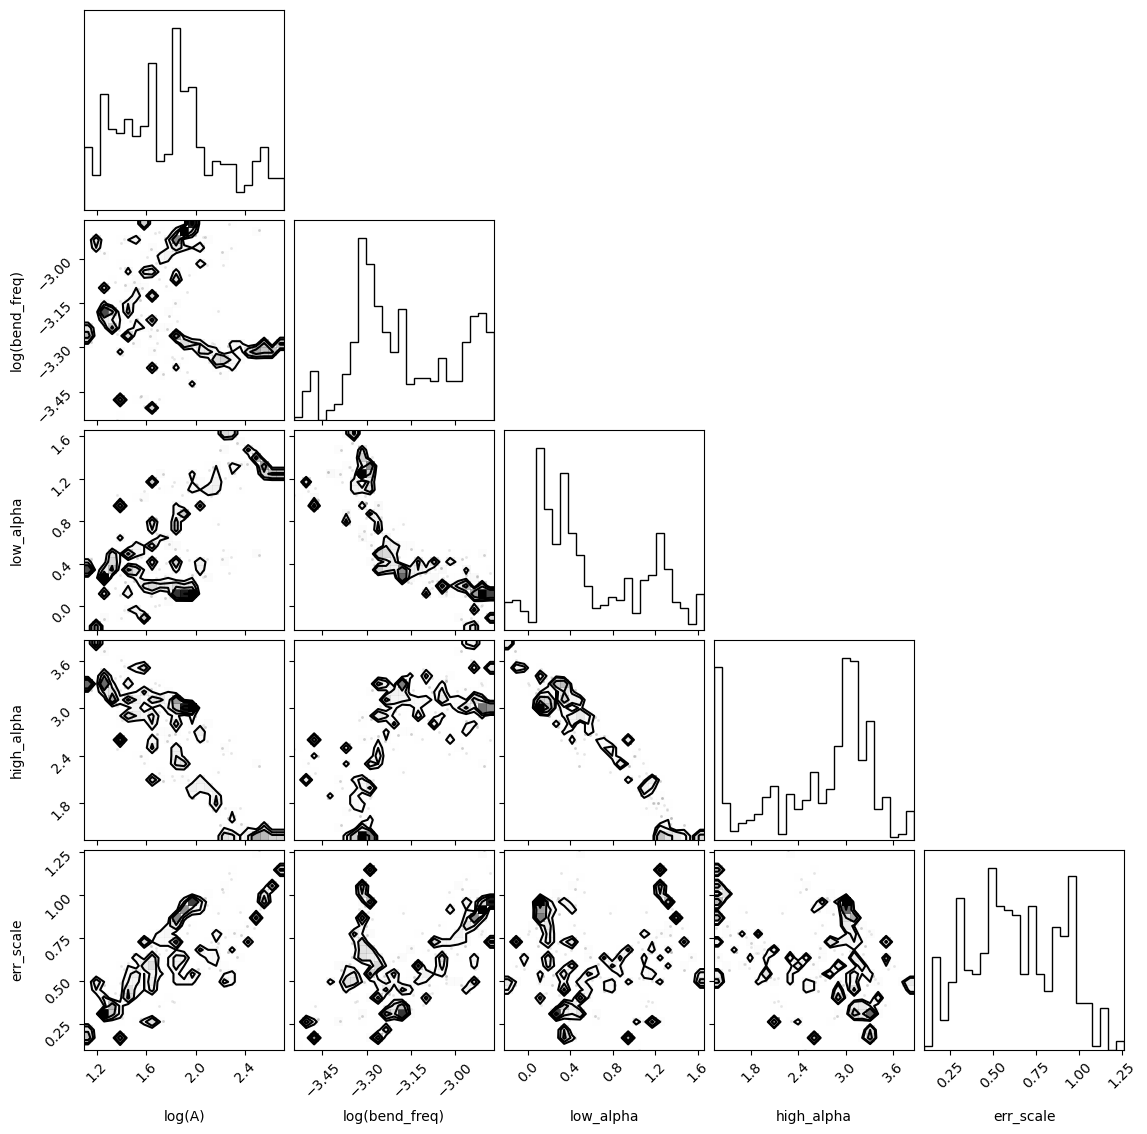

In [399]:
labels = ["log(A)", "log(bend_freq)", "low_alpha", "high_alpha",  "err_scale"]
fig = corner.corner( flat_samples, labels=labels, bins = 25)

In [400]:
samples = sampler.get_chain(discard=50, flat=False)
np.shape(samples), 

((50, 10, 5),)

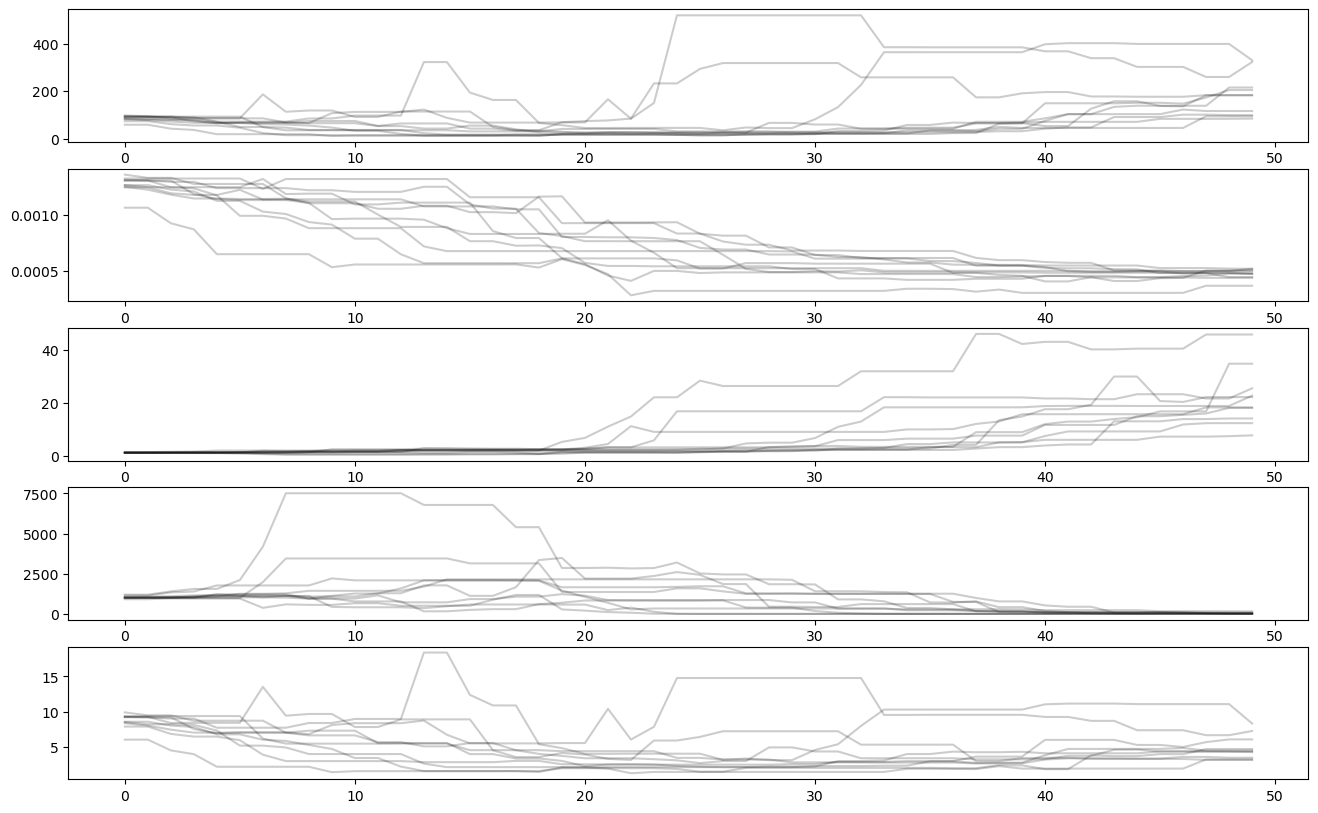

In [404]:
samples = sampler.get_chain(discard=50)

fig, ax = plt.subplots(5,1, figsize=[16,10])
for i in range(5):
    for j in np.random.choice(np.arange(0, 10), size=10, replace=False):
        ax[i].plot(10**samples[:,j,i], 'k-', alpha =0.2)

## Passed model

In [218]:
simDATA = pd.read_csv('simDATAcsvs/simDATA_highALPHA_3_NumofWINDOW_4_20.csv')
row = simDATA[1692:1693]
row
def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    '''
    Function for bend power_law creation
    '''
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod

l = LightCurveSampler(N=2**21, rms=float(row.rms), simulatorSEED= int(row.simSEED), verbose=False)
l.load_powerspec(bend_pl, [200,  float(row.bendfreq), 
                            float(row.lowalpha),
                            float(row.highalpha),
                            float(row.sharpness)], 
                            plot=False)
l.LCsimulator()
simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = int(row.NightsperWINDOW), 
                                            NumofWINDOW = int(row.NumofWINDOW),
                                            OBSperiod = float(row.OBSperiod),
                                            WINDOWwidth = float(row.WINDOWwidth),
                                            samplerSEED = int(row.sampleSEED),
                                            dataLOSSfrac = float(row.dataLOSSfrac), 
                                            noiseSIGMA = float(row.noiseSIGMA), plot=False)
print(np.argmin(np.diff(simTIME)))


230


In [219]:
initial_guess = [np.log10(100), np.log10(0.5/365), 1]

nwalkers = 30
ndim = 3
sampler = emcee.EnsembleSampler(nwalkers, ndim, DRW_log_posterior, args=(simTIME, simLC, simLCerr))

nsteps = 2000
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)
res = sampler.run_mcmc(pos, nsteps, progress =True)


100%|██████████| 2000/2000 [17:40<00:00,  1.89it/s]


In [224]:
flat_samples = sampler.get_chain(discard=0, flat=True)


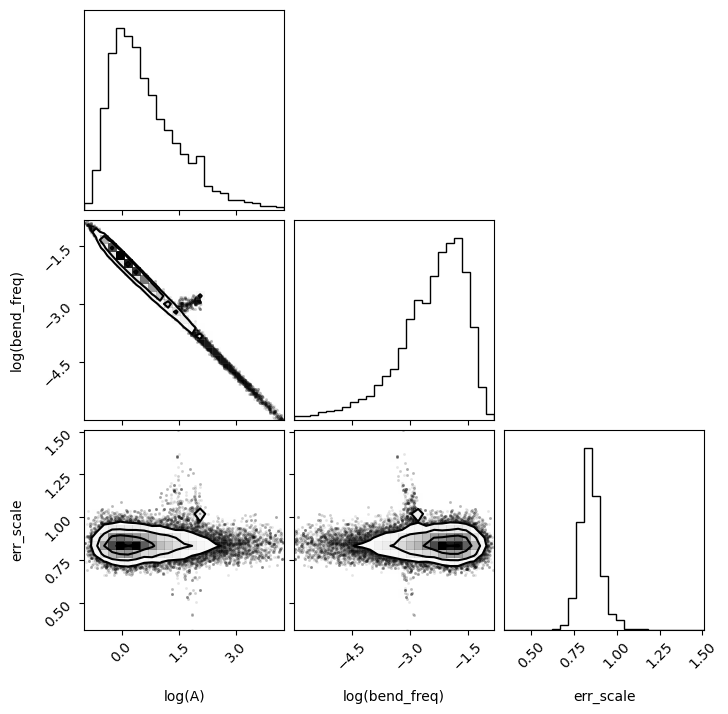

In [225]:
labels = ["log(A)", "log(bend_freq)", "err_scale"]
fig = corner.corner( flat_samples, labels=labels, bins = 25)


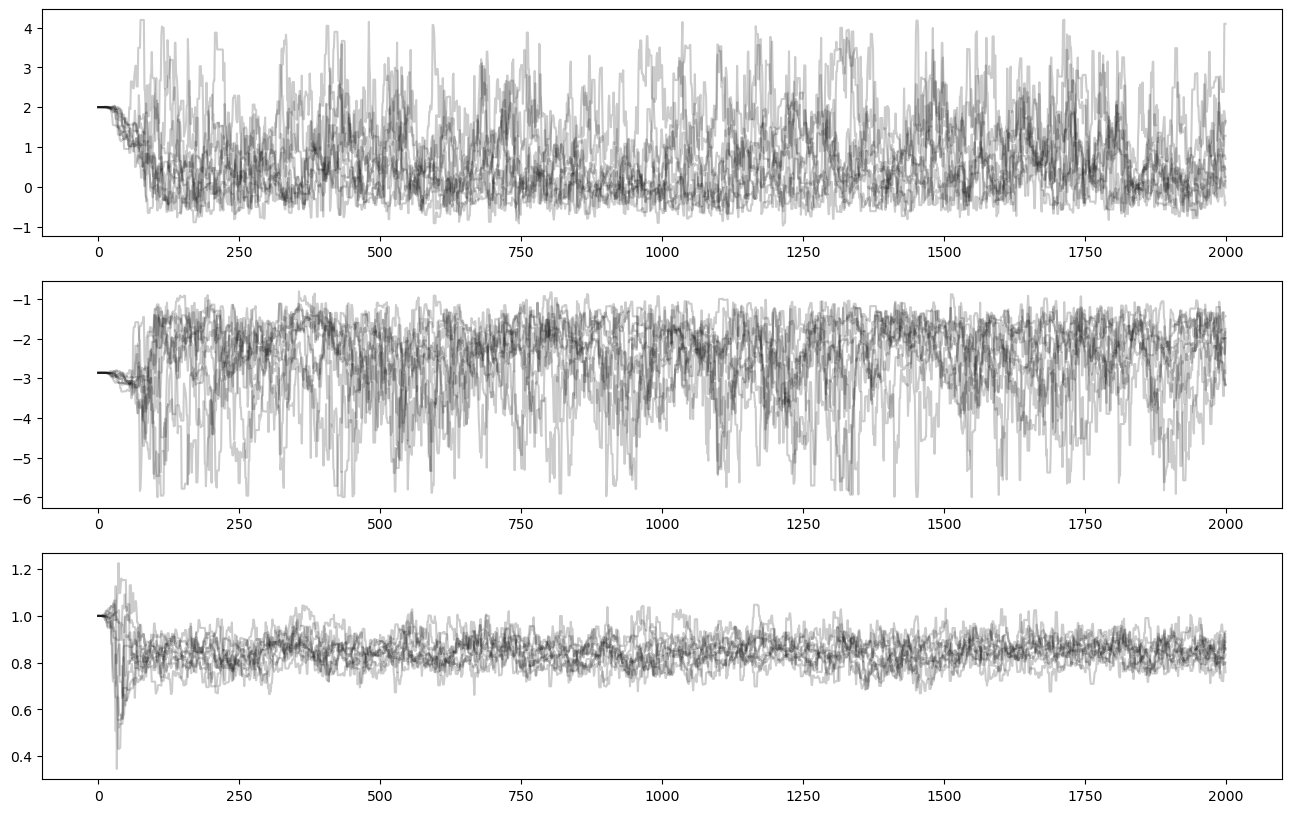

In [227]:
samples = sampler.get_chain(discard=0)

fig, ax = plt.subplots(3,1, figsize=[16,10])
for i in range(3):
    for j in np.random.choice(np.arange(0, 30), size=10, replace=False):
        ax[i].plot(samples[:,j,i], 'k-', alpha =0.2)

## sampling bug test

In [2]:
DRW_filenames = glob.glob('helios_files/results_NumofWINDOW_4_20/json_files/highALPHA_3_NumofWINDOW_4_20/outputs/*DRW.*')
DRW_filenames.sort()
DRWsine_filenames = glob.glob('helios_files/results_NumofWINDOW_4_20/json_files/highALPHA_3_NumofWINDOW_4_20/outputs/*DRWsine.*')
DRWsine_filenames.sort()
CARMA21_filenames = glob.glob('helios_files/results_NumofWINDOW_4_20/json_files/highALPHA_3_NumofWINDOW_4_20/outputs/*CARMA21.*')
CARMA21_filenames.sort()
CARMA21sine_filenames = glob.glob('helios_files/results_NumofWINDOW_4_20/json_files/highALPHA_3_NumofWINDOW_4_20/outputs/*CARMA21sine.*')
CARMA21sine_filenames.sort()
OBPL10_filenames = glob.glob('helios_files/results_NumofWINDOW_4_20/json_files/highALPHA_3_NumofWINDOW_4_20/outputs/*OBPL10.*')
OBPL10_filenames.sort()
OBPLsine10_filenames = glob.glob('helios_files/results_NumofWINDOW_4_20/json_files/highALPHA_3_NumofWINDOW_4_20/outputs/*OBPLsine10.*')
OBPLsine10_filenames.sort()

In [3]:
DRW_IDs = []
DRWsine_IDs = []
CARMA21_IDs = []
CARMA21sine_IDs = []
OBPL10_IDs = []
OBPLsine10_IDs = []

for val in DRW_filenames:
    DRW_IDs.append(int(val[86:90]))
for val in DRWsine_filenames:
    DRWsine_IDs.append(int(val[86:90]))
for val in CARMA21_filenames:
    CARMA21_IDs.append(int(val[86:90]))
for val in CARMA21sine_filenames:
    CARMA21sine_IDs.append(int(val[86:90]))
for val in OBPL10_filenames:
    OBPL10_IDs.append(int(val[86:90]))
for val in OBPLsine10_filenames:
    OBPLsine10_IDs.append(int(val[86:90]))
def find_common_elements(arrays):
    if not arrays:
        return []

    # Convert the first array to a set
    common_elements = set(arrays[0])

    # Iterate through the rest of the arrays and find the intersection
    for array in arrays[1:]:
        common_elements.intersection_update(array)

    return list(common_elements)

common_IDs = find_common_elements([DRW_IDs, DRWsine_IDs, CARMA21_IDs, CARMA21sine_IDs, OBPL10_IDs, OBPLsine10_IDs])

In [4]:
simDATA = pd.read_csv('helios_files/simDATAcsvs/simDATA_highALPHA_3_NumofWINDOW_4_20.csv')


In [5]:
simDATA = pd.read_csv('simDATAcsvs/simDATA_highALPHA_3_NumofWINDOW_4_20.csv')
def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    '''
    Function for bend power_law creation
    '''
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod

simDATA['minTIME'] = -1
simDATA

,ID,simSEED,sampleSEED,rms,noiseSIGMA,bendfreq,lowalpha,highalpha,sharpness,NumofWINDOW,NightsperWINDOW,OBSperiod,WINDOWwidth,dataLOSSfrac,minTIME
0,1000.0,48090.0,83055.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,4.0,20,6,60,0.2,-1
1,1001.0,59982.0,23885.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,4.0,20,6,60,0.2,-1
2,1002.0,95580.0,42170.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,4.0,20,6,60,0.2,-1
3,1003.0,86308.0,43423.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,4.0,20,6,60,0.2,-1
4,1004.0,7357.0,86838.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,4.0,20,6,60,0.2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695,2695.0,12372.0,95589.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,20.0,20,6,60,0.2,-1
1696,2696.0,75974.0,42835.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,20.0,20,6,60,0.2,-1
1697,2697.0,40384.0,77520.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,20.0,20,6,60,0.2,-1
1698,2698.0,40895.0,21505.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,20.0,20,6,60,0.2,-1


In [6]:
for i, row in simDATA.iterrows():
    l = LightCurveSampler(N=2**21, rms=float(row.rms), simulatorSEED= int(row.simSEED), verbose=False)
    l.load_powerspec(bend_pl, [200,  float(row.bendfreq), 
                                float(row.lowalpha),
                                float(row.highalpha),
                                float(row.sharpness)], 
                                plot=False)
    l.LCsimulator()
    simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = int(row.NightsperWINDOW), 
                                                NumofWINDOW = int(row.NumofWINDOW),
                                                OBSperiod = float(row.OBSperiod),
                                                WINDOWwidth = float(row.WINDOWwidth),
                                                samplerSEED = int(row.sampleSEED),
                                                dataLOSSfrac = float(row.dataLOSSfrac), 
                                                noiseSIGMA = float(row.noiseSIGMA), plot=False)
    
    print(row.ID, end = '-->')
    simDATA.loc[simDATA.ID ==  int(row.ID),'minTIME'] = np.min(np.diff(simTIME))

1000.0-->1001.0-->1002.0-->1003.0-->1004.0-->1005.0-->1006.0-->1007.0-->1008.0-->1009.0-->1010.0-->1011.0-->1012.0-->1013.0-->1014.0-->1015.0-->1016.0-->1017.0-->1018.0-->1019.0-->1020.0-->1021.0-->1022.0-->1023.0-->1024.0-->1025.0-->1026.0-->1027.0-->1028.0-->1029.0-->1030.0-->1031.0-->1032.0-->1033.0-->1034.0-->1035.0-->1036.0-->1037.0-->1038.0-->1039.0-->1040.0-->1041.0-->1042.0-->1043.0-->1044.0-->1045.0-->1046.0-->1047.0-->1048.0-->1049.0-->1050.0-->1051.0-->1052.0-->1053.0-->1054.0-->1055.0-->1056.0-->1057.0-->1058.0-->1059.0-->1060.0-->1061.0-->1062.0-->1063.0-->1064.0-->1065.0-->1066.0-->1067.0-->1068.0-->1069.0-->1070.0-->1071.0-->1072.0-->1073.0-->1074.0-->1075.0-->1076.0-->1077.0-->1078.0-->1079.0-->1080.0-->1081.0-->1082.0-->1083.0-->1084.0-->1085.0-->1086.0-->1087.0-->1088.0-->1089.0-->1090.0-->1091.0-->1092.0-->1093.0-->1094.0-->1095.0-->1096.0-->1097.0-->1098.0-->1099.0-->1100.0-->1101.0-->1102.0-->1103.0-->1104.0-->1105.0-->1106.0-->1107.0-->1108.0-->1109.0-->1110.0-->1

In [7]:
simDATA_cropped = simDATA.loc[np.array(common_IDs)-1000]
set_filterd = set(simDATA_cropped.sort_values("ID").ID.to_numpy())
set_base = set(simDATA.sort_values("ID").ID.to_numpy())
failed_IDs = list(set_base - set_filterd)
failed_IDs.sort()

In [8]:
simDATA.loc[np.array(failed_IDs).astype('int')-1000]

,ID,simSEED,sampleSEED,rms,noiseSIGMA,bendfreq,lowalpha,highalpha,sharpness,NumofWINDOW,NightsperWINDOW,OBSperiod,WINDOWwidth,dataLOSSfrac,minTIME
1,1001.0,59982.0,23885.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,4.0,20,6,60,0.2,0.000114
8,1008.0,61828.0,52748.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,4.0,20,6,60,0.2,0.000057
9,1009.0,12087.0,6630.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,4.0,20,6,60,0.2,0.000190
115,1115.0,30568.0,40665.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,5.0,20,6,60,0.2,0.000057
122,1122.0,60784.0,62190.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,5.0,20,6,60,0.2,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694,2694.0,34715.0,55904.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,20.0,20,6,60,0.2,0.000076
1695,2695.0,12372.0,95589.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,20.0,20,6,60,0.2,0.000076
1697,2697.0,40384.0,77520.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,20.0,20,6,60,0.2,0.000038
1698,2698.0,40895.0,21505.0,0.15,0.015,0.00274,-1.0,-3.0,10.0,20.0,20,6,60,0.2,0.000019


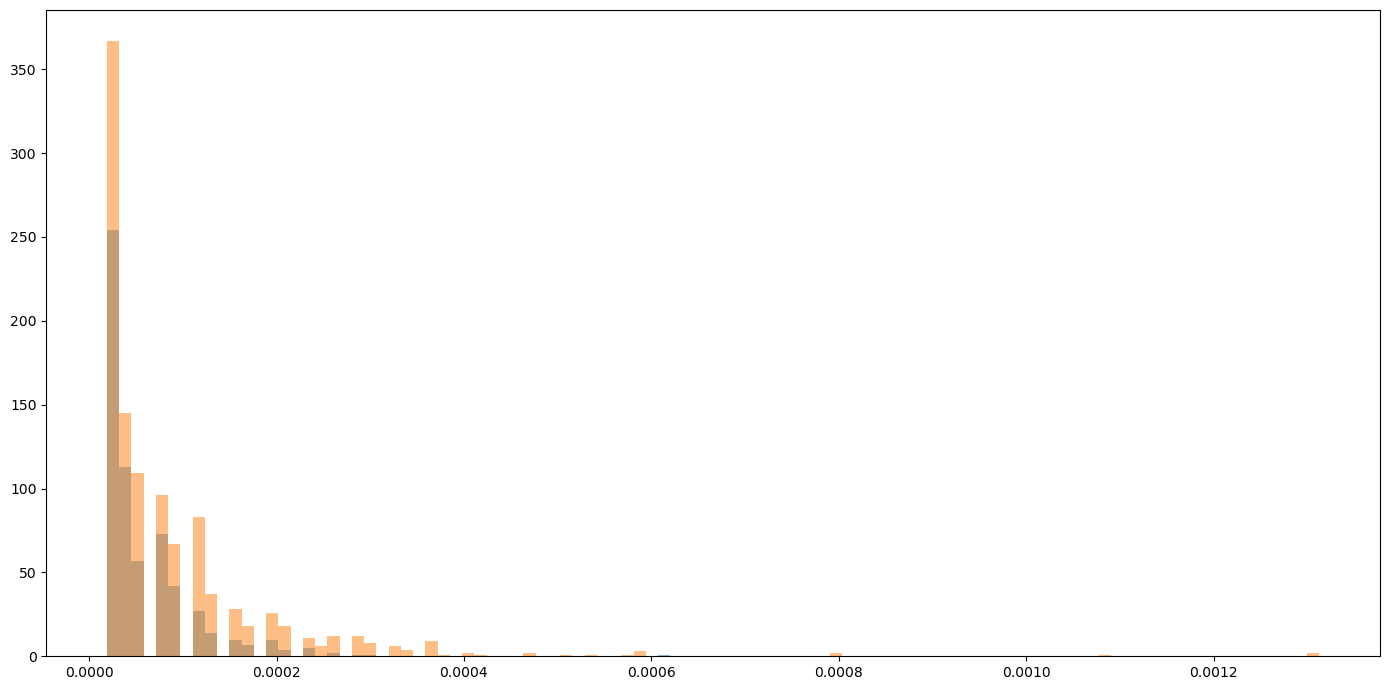

In [9]:
plt.figure(figsize=[14,7])
plt.hist(simDATA.loc[np.array(failed_IDs).astype('int')-1000].minTIME, bins=np.linspace(min(simDATA.minTIME), max(simDATA.minTIME), 100 ), alpha = 0.5)
plt.hist(simDATA_cropped.minTIME, bins=np.linspace(min(simDATA.minTIME), max(simDATA.minTIME), 100 ), alpha = 0.5 )
plt.tight_layout()
plt.show()

array([0.00000000e+00, 1.28133445e-05, 2.56266890e-05, 3.84400335e-05,
       5.12533781e-05, 6.40667226e-05, 7.68800671e-05, 8.96934116e-05,
       1.02506756e-04, 1.15320101e-04, 1.28133445e-04, 1.40946790e-04,
       1.53760134e-04, 1.66573479e-04, 1.79386823e-04, 1.92200168e-04,
       2.05013512e-04, 2.17826857e-04, 2.30640201e-04, 2.43453546e-04,
       2.56266890e-04, 2.69080235e-04, 2.81893579e-04, 2.94706924e-04,
       3.07520268e-04, 3.20333613e-04, 3.33146957e-04, 3.45960302e-04,
       3.58773646e-04, 3.71586991e-04, 3.84400335e-04, 3.97213680e-04,
       4.10027025e-04, 4.22840369e-04, 4.35653714e-04, 4.48467058e-04,
       4.61280403e-04, 4.74093747e-04, 4.86907092e-04, 4.99720436e-04,
       5.12533781e-04, 5.25347125e-04, 5.38160470e-04, 5.50973814e-04,
       5.63787159e-04, 5.76600503e-04, 5.89413848e-04, 6.02227192e-04,
       6.15040537e-04, 6.27853881e-04])